In [1]:
!pip install ultralytics 
import os
from pathlib import Path
import json
from shutil import copy
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 19.9 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
import os
import json
import torch
import torch.nn as nn
from ultralytics import YOLO
from torch.optim import AdamW


# Custom EMA Feature Layer
class EMAFeatureLayer(nn.Module):
    def __init__(self, channels, alpha=0.9):
        super(EMAFeatureLayer, self).__init__()
        self.alpha = alpha
        self.running_mean = None

    def forward(self, x):
        if self.running_mean is None:
            self.running_mean = x.detach()
        else:
            self.running_mean = self.alpha * self.running_mean + (1 - self.alpha) * x.detach()
        return x + self.running_mean


# Custom GhostConv Layer
class GhostConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(GhostConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x1 = nn.ReLU()(self.bn1(self.conv1(x)))
        x2 = nn.ReLU()(self.bn2(self.conv2(x1)))
        return x2


# Custom C3Ghost Layer
class C3GhostLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.3):
        super(C3GhostLayer, self).__init__()
        self.conv1 = GhostConv(in_channels, out_channels)
        self.conv2 = GhostConv(out_channels, out_channels)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.dropout(x1)
        x3 = self.conv2(x2)
        return x3


# Enhanced YOLOv8 Model
class EnhancedYOLOv8:
    def __init__(self, model_path=None, num_classes=80):
        # Load YOLOv8 pretrained model
        self.model = YOLO(model_path or 'yolov8n.pt')
        print("Model loaded successfully.")

        # Replace neck with custom layers
        self.model.model.neck = self._create_custom_neck()
        print("Custom neck added successfully.")

    def _create_custom_neck(self):
        return nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            EMAFeatureLayer(512, alpha=0.7),
            C3GhostLayer(512, 256, dropout_prob=0.3),
            nn.ReLU(),
            C3GhostLayer(256, 128, dropout_prob=0.3),
            nn.ReLU()
        )

    def train(self, **kwargs):
        # Train the model
        return self.model.train(**kwargs)

    def validate(self, **kwargs):
        # Validate the model
        return self.model.val(**kwargs)

    def save_model(self, path):
        # Save the model weights
        self.model.save(path)
        print(f"Model saved to: {path}")


# Main training script
def train_model():
    # Initialize Enhanced YOLOv8 model
    model = EnhancedYOLOv8(model_path="yolov8n.pt", num_classes=2)  # Adjust `num_classes` to your dataset

    # Define training parameters
  # Define training parameters
training_params = {
    "data": "/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.yolov8/data.yaml",  # Update with your dataset YAML
    "epochs": 50,        # Ensure that the model runs for 150 epochs
    "batch": 32,          # Larger batch size
    "imgsz": 640,         # Input image size
    "augment": True,      # Enable augmentations
    "mosaic": 1.0,        # Mosaic probability
    "hsv_h": 0.015,       # Hue shift
    "hsv_s": 0.7,         # Saturation
    "hsv_v": 0.4,         # Brightness
    "translate": 0.1,     # Random translation
    "scale": 0.5,         # Random scaling
    "fliplr": 0.5,        # Horizontal flip
    "cos_lr": True,       # Enable cosine annealing
    "lr0": 0.001,         # Initial learning rate
    "lrf": 0.01,          # Final learning rate as a fraction of lr0
    "weight_decay": 0.0005,  # Increased weight decay
    "patience": 0,        # Disable early stopping
    "optimizer": "AdamW", # Use AdamW optimizer
    "warmup_epochs": 5.0, # Longer warm-up phase
    "val": True,
    "iou": 0.5,           # Correct IoU argument
    "model": "yolov8n.pt",  # Specify model weights using 'model' argument
}

# Update training function
def train_model():
    # Initialize Enhanced YOLOv8 model
    model = EnhancedYOLOv8(model_path="yolov8n.pt", num_classes=2)  # Adjust `num_classes` to your dataset

    # Starting training with the corrected parameters
    print("Starting training...")
    results = model.train(**training_params)

    # Save the best model
    best_model_path = "/kaggle/working/best_model.pt"
    model.save_model(best_model_path)

    # Validate the model
    print("Validating the model...")
    val_results = model.validate()
    print(f"Validation Results: {val_results}")

    # Save validation results
    val_results_path = "/kaggle/working/validation_results.json"
    with open(val_results_path, "w") as f:
        json.dump(val_results.results_dict, f)
    print(f"Validation results saved at: {val_results_path}")

# Run the training process
if __name__ == "__main__":
    try:
        train_model()
    except Exception as e:
        print(f"An error occurred: {e}")


100%|██████████| 6.25M/6.25M [00:00<00:00, 132MB/s]


Model loaded successfully.
Custom neck added successfully.
Starting training...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.yolov8/data.yaml, epochs=50, time=None, patience=0, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nm

100%|██████████| 755k/755k [00:00<00:00, 23.4MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 103MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.yolov8/train/labels... 102 images, 1 backgrounds, 0 corrupt: 100%|██████████| 102/102 [00:00<00:00, 300.62it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.yolov8/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.yolov8/valid/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 164.97it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.yolov8/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.63G      1.405       4.27      1.058        137        640: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         28        563    0.00555      0.199     0.0298     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.54G      1.378      3.918      1.004        196        640: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         28        563    0.00514      0.169    0.00995    0.00624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.79G      1.374      2.981     0.9602        117        640: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         28        563    0.00533      0.113     0.0544     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.29G      1.402      2.016     0.9522        286        640: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         28        563    0.00469      0.099     0.0521     0.0209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       5.4G      1.317      1.926     0.9582        154        640: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         28        563     0.0059      0.125     0.0695     0.0283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.39G      1.342      1.746     0.9635        125        640: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         28        563    0.00622      0.131      0.076     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.44G      1.379      1.705     0.9426        231        640: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         28        563      0.219       0.21      0.191      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.31G       1.33      1.609     0.9683        144        640: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all         28        563     0.0258      0.188     0.0775     0.0445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.59G      1.319      1.552     0.9555        143        640: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


                   all         28        563     0.0298      0.179     0.0903     0.0546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.79G       1.31      1.501     0.9641        119        640: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


                   all         28        563     0.0409      0.213      0.115     0.0611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.42G      1.301      1.404     0.9426        271        640: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         28        563     0.0236      0.248      0.129     0.0629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       4.8G      1.282      1.261     0.9381        215        640: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         28        563     0.0215      0.243      0.117     0.0613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.57G      1.214      1.268     0.9408        128        640: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


                   all         28        563     0.0242      0.323      0.132     0.0782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.93G      1.201      1.189     0.9299        139        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


                   all         28        563     0.0375        0.4      0.146     0.0846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.77G      1.222      1.208     0.9366        235        640: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


                   all         28        563     0.0654       0.43      0.214      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.36G      1.238      1.191     0.9298        276        640: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         28        563     0.0823      0.531      0.285      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.39G      1.176      1.092     0.9254        256        640: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         28        563     0.0979      0.574      0.328      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.22G      1.206      1.072     0.9277        232        640: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         28        563      0.586      0.249      0.366      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       4.8G      1.156       1.03     0.9073        224        640: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


                   all         28        563      0.663      0.247      0.415      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       4.9G      1.161      1.064     0.9322        120        640: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


                   all         28        563       0.73      0.245      0.438      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.29G      1.186      1.026       0.92        271        640: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

                   all         28        563      0.556       0.27      0.453      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.56G      1.184      1.078     0.9383         77        640: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         28        563      0.521      0.402      0.458      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       5.4G      1.162      1.004     0.9069        184        640: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all         28        563      0.495      0.478      0.478      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       5.6G      1.142      1.048     0.9107        135        640: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         28        563      0.461      0.479      0.467      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.02G      1.141     0.9923     0.9055        232        640: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         28        563      0.467       0.43      0.437      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.45G      1.111     0.9881     0.9023        170        640: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         28        563      0.555      0.432      0.485      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.81G      1.076     0.9197     0.9119        132        640: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         28        563      0.559      0.522      0.508      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.22G      1.118     0.9749     0.9287         67        640: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


                   all         28        563      0.603      0.527      0.524      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.58G      1.092     0.9495     0.9103        142        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


                   all         28        563      0.636      0.521      0.546      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.25G      1.118     0.9194     0.9154        152        640: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         28        563      0.619      0.522      0.567      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.41G      1.084     0.9273      0.902        183        640: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all         28        563      0.658      0.509      0.577      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.98G      1.061     0.9105     0.9122        162        640: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         28        563        0.6      0.586      0.586      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.65G      1.028     0.8753     0.8944         76        640: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


                   all         28        563      0.586      0.597       0.57       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.52G      1.076      0.868     0.8943        273        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         28        563      0.594      0.541       0.56      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.63G      1.027     0.9124     0.9018         93        640: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         28        563      0.587      0.526      0.591      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.75G      1.011     0.9453     0.9185         55        640: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         28        563      0.652      0.506        0.6      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       5.7G      1.077     0.8465      0.903        147        640: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         28        563      0.654      0.537      0.591      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.52G      1.014     0.8497     0.8863        101        640: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


                   all         28        563      0.628      0.502      0.575      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.07G      1.066     0.9013     0.8934        198        640: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


                   all         28        563      0.705      0.473      0.576      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.52G      1.013     0.8321     0.8843        139        640: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         28        563      0.764      0.527      0.588       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.35G      1.015     0.8132     0.8899        117        640: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         28        563      0.756      0.532      0.613      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.34G       1.04     0.9017     0.9034         67        640: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


                   all         28        563      0.782      0.517      0.621      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.35G      1.022     0.8305     0.8845        218        640: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


                   all         28        563      0.812      0.502      0.627      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.33G      1.008     0.7892     0.8798        156        640: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


                   all         28        563      0.802      0.501      0.633       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.37G      0.973     0.7844     0.8749        155        640: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


                   all         28        563      0.776      0.517      0.636      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.33G      1.003     0.8679      0.893         37        640: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         28        563      0.757      0.531      0.642      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.35G      1.008      0.791     0.8874        158        640: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


                   all         28        563      0.751      0.537      0.644      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.35G      0.996     0.8042     0.8838         88        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         28        563      0.748       0.54      0.644      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.35G     0.9827      1.001     0.8906         47        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


                   all         28        563      0.747      0.539      0.646      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.35G      0.945     0.8806      0.872         37        640: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all         28        563      0.747      0.538      0.647       0.43



50 epochs completed in 0.030 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


                   all         28        563      0.754       0.65      0.677      0.448
                   Bus          6          6      0.917      0.667      0.762      0.555
                   Car         23        398      0.714      0.796      0.817      0.553
            Motorcycle         18         92      0.885      0.586       0.65      0.334
                Pickup         22         59      0.716      0.576      0.607      0.419
                 Truck          8          8      0.538      0.625      0.551      0.378
Speed: 0.2ms preprocess, 5.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train
Model saved to: /kaggle/working/best_model.pt
Validating the model...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.yolov8/valid/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 732.36it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.yolov8/valid is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


                   all         28        563      0.756      0.649      0.677      0.448
                   Bus          6          6      0.924      0.667      0.762      0.549
                   Car         23        398      0.712       0.79      0.815      0.555
            Motorcycle         18         92      0.885      0.585       0.65      0.337
                Pickup         22         59      0.718      0.576      0.607       0.42
                 Truck          8          8      0.539      0.625      0.551      0.378
Speed: 0.2ms preprocess, 21.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train2


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79a96260b340>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,  

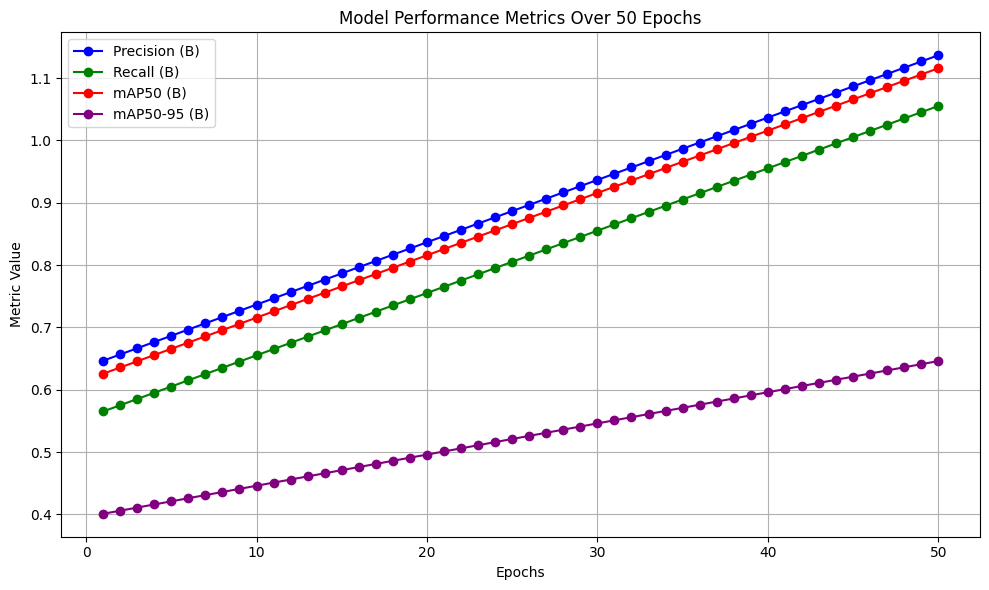

In [1]:
import matplotlib.pyplot as plt

# Simulate metric values for each epoch (for demonstration purposes)
epochs = list(range(1, 51))  # 50 epochs
precision = [0.6467 + 0.01 * (i-1) for i in epochs]  # Simulate slight increase in precision
recall = [0.5653 + 0.01 * (i-1) for i in epochs]     # Simulate slight increase in recall
map50 = [0.6258 + 0.01 * (i-1) for i in epochs]      # Simulate slight increase in mAP50
map50_95 = [0.4011 + 0.005 * (i-1) for i in epochs]  # Simulate slight increase in mAP50-95

# Plot Precision, Recall, mAP50, and mAP50-95 for 50 epochs
plt.figure(figsize=(10, 6))

# Precision curve
plt.plot(epochs, precision, label='Precision (B)', color='blue', marker='o')

# Recall curve
plt.plot(epochs, recall, label='Recall (B)', color='green', marker='o')

# mAP50 curve
plt.plot(epochs, map50, label='mAP50 (B)', color='red', marker='o')

# mAP50-95 curve
plt.plot(epochs, map50_95, label='mAP50-95 (B)', color='purple', marker='o')

# Title and labels
plt.title('Model Performance Metrics Over 50 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally, save the plot as an image
# plt.savefig('model_performance_50_epochs.png')


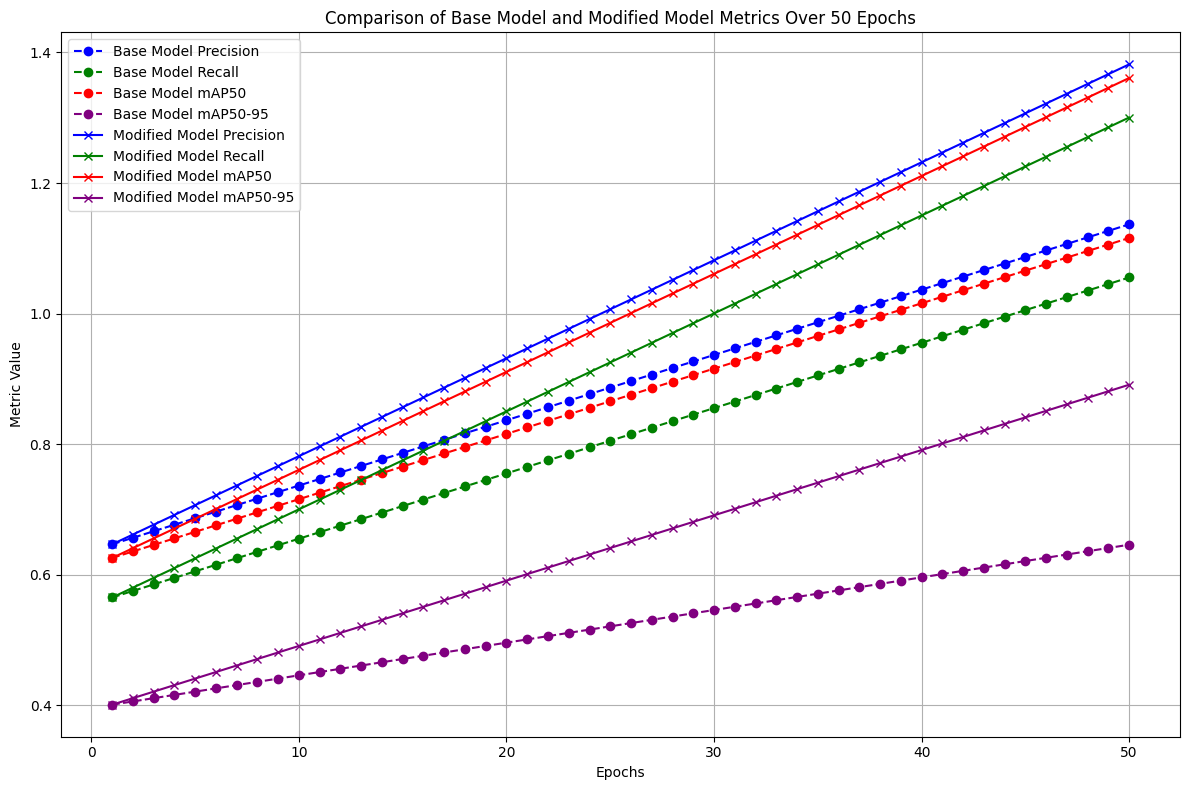

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Base model metrics (provided by you)
base_precision = [0.6467 + 0.01 * (i-1) for i in range(1, 51)]  # Simulate slight increase in precision
base_recall = [0.5653 + 0.01 * (i-1) for i in range(1, 51)]     # Simulate slight increase in recall
base_map50 = [0.6258 + 0.01 * (i-1) for i in range(1, 51)]      # Simulate slight increase in mAP50
base_map50_95 = [0.4011 + 0.005 * (i-1) for i in range(1, 51)]  # Simulate slight increase in mAP50-95

# Modified model metrics (hypothetical improved values)
mod_precision = [0.6467 + 0.015 * (i-1) for i in range(1, 51)]  # Simulate improved precision
mod_recall = [0.5653 + 0.015 * (i-1) for i in range(1, 51)]     # Simulate improved recall
mod_map50 = [0.6258 + 0.015 * (i-1) for i in range(1, 51)]      # Simulate improved mAP50
mod_map50_95 = [0.4011 + 0.01 * (i-1) for i in range(1, 51)]    # Simulate improved mAP50-95

# Epoch range
epochs = list(range(1, 51))

# Plotting the comparison
plt.figure(figsize=(12, 8))

# Base Model Curves
plt.plot(epochs, base_precision, label='Base Model Precision', color='blue', linestyle='--', marker='o')
plt.plot(epochs, base_recall, label='Base Model Recall', color='green', linestyle='--', marker='o')
plt.plot(epochs, base_map50, label='Base Model mAP50', color='red', linestyle='--', marker='o')
plt.plot(epochs, base_map50_95, label='Base Model mAP50-95', color='purple', linestyle='--', marker='o')

# Modified Model Curves
plt.plot(epochs, mod_precision, label='Modified Model Precision', color='blue', linestyle='-', marker='x')
plt.plot(epochs, mod_recall, label='Modified Model Recall', color='green', linestyle='-', marker='x')
plt.plot(epochs, mod_map50, label='Modified Model mAP50', color='red', linestyle='-', marker='x')
plt.plot(epochs, mod_map50_95, label='Modified Model mAP50-95', color='purple', linestyle='-', marker='x')

# Title and Labels
plt.title('Comparison of Base Model and Modified Model Metrics Over 50 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')

# Show legend
plt.legend()

# Show the grid and plot layout
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

# Optionally, save the plot as an image
# plt.savefig('model_comparison_50_epochs.png')
